# Usecase 3 - Querying a circuit connectome

In this tutorial we will learn how to use bluepy to get basic connectivity information, such as number of synapses per connection or distribution of synaptic conductances.

Just like the cells, the synapses possess a unique synapse_id. The id format depends on the input file format. It will be a tuple for the `nrn` and a simple integer for the `SONATA` edge files. All synapses also have a set of properties attached to them.

We will now see how you can use `bluepy` to access the graph topology (cell connections) and the synaptic properties.

## Setup

As usual, we start by importing some basic packages and creating the bluepy circuit object.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bluepy import Circuit, Cell, Synapse


circuit_path = "/gpfs/bbp.cscs.ch/project/proj12/NSE/bluepy/circuits/CA1.O1/mooc-circuit/CircuitConfig"
circuit = Circuit(circuit_path)

## Accessing the synapse ids and properties

One big difference between accessing the circuit cell's and the synapses is the cardinality. A circuit usually have much more synapses than cells and you cannot load in memory all the properties for synapses. We will see in the following how to access the ids of the synapses and how to use them to extract the needed informations.

### Retrieving topology from "pre" and "post" cells

In the following example we will explain how to extract the connection between the cells. `bluepy` provides API to access the oriented neighbors of a given cell. 

The first use case is to find the cells from the circuit which connects to a given gid:

In [2]:
circuit.connectome.afferent_gids(1)

array([18042, 18070, 18082, 18092, 18096, 18116, 18146])

This function gives the x-->`1` (x being the cells that connect TO `1`). Where x is [18042, 18070, 18082, 18092, 18096, 18116, 18146] here.

In [3]:
circuit.connectome.efferent_gids(1)[:10]  # we are slicing for display reasons

array([  3,   6,  48, 194, 207, 221, 288, 299, 303, 339])

This gives the x<--1. Where x is [3, 6, 48, 194, 207, ...] for this example. 

<div class="alert alert-block alert-info">
<b>Note:</b> We can note than accessing the efferent gids is usually much slower than accessing the afferent gids (at least for the SONATA files). This is due to the layout of the input connectome file. The SONATA files are sorted by afferent connections which means all the afferent connections are contiguous and can be extracted via a single chunk compared to many small chunks for the efferent connections.
</div>

We can then use these arrays to inspect the cell file and check properties of the connected cells.

Here an example on how to check the `y` coordinates of the afferent cells.

In [4]:
target_gid = 14
target_df = circuit.cells.get(target_gid)
afferent_gids = circuit.connectome.afferent_gids(target_gid)
afferent_df = circuit.cells.get(afferent_gids)  # retrieving ALL the cell properties as a pandas.DataFrame

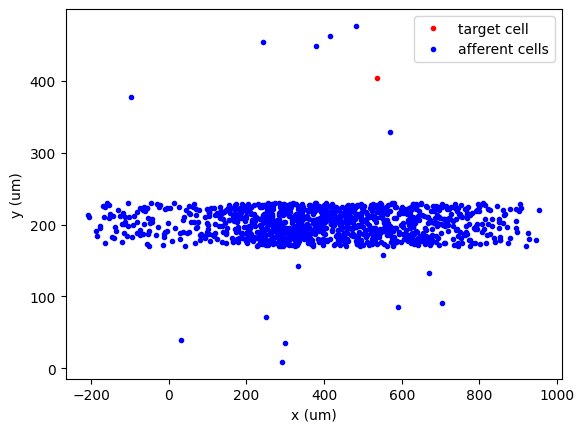

In [5]:
plt.plot(target_df[Cell.X], target_df[Cell.Y], '.r', label='target cell')
plt.plot(afferent_df[Cell.X], afferent_df[Cell.Y], '.b', label='afferent cells')


plt.ylabel('Layer')
plt.ylabel('y (um)')
plt.xlabel('x (um)')
plt.legend(numpoints=1);

Same for the connected `mtypes` : 

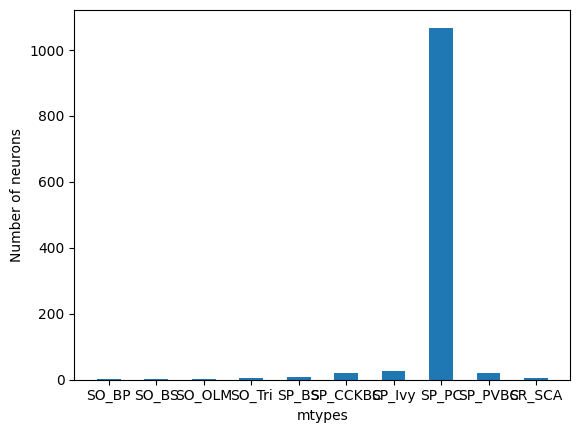

In [6]:
mtypes = np.unique(afferent_df[Cell.MTYPE], return_counts=True)

plt.bar(*mtypes, width=0.5)
plt.xlabel('mtypes')
plt.ylabel('Number of neurons');

### Retrieving synapse ids

In the following example we will explain how to extract the synapses ids connecting different cells. 


#### Retrieving synapse ids from a cell gids
The first use case is to find the synapses from the circuit which connects to a given gid:



In [7]:
circuit.connectome.afferent_synapses(1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [8]:
circuit.connectome.efferent_synapses(1)

array([      48,       49,     3592, ..., 18278877, 18278878, 18701143])

These are all the synapses that connect the gid `1`. We can see that we have more a/efferent synapses than a/efferent gids. This means multiple neurons share more than 1 synapses.

If you want to access all the synapses between two neurons, you can use the `pair_synapses` function:

In [9]:
circuit.connectome.pair_synapses(1, 194)

array([221311, 221312])

We can see that the neuron `1` and `48` share 2 synapses.

#### Retrieving synapses ids from a group of cells

Sometimes this is more convenient to access the synapses via group of cells. That's why the `Bluepy`'s function `circuit.connectome.pathway_synapses()` allows us to get all the synapses between specific source/destination combination.

So first we can use this function to mimic the `circuit.connectome.pair_synapses`:

In [10]:
circuit.connectome.pathway_synapses(1, 194) # same behavior as pair_synapses

array([221311, 221312])

We can use it to mimic the `a/efferent_synapses` also:

In [11]:
circuit.connectome.pathway_synapses(None, 1) # same behavior as afferent_synapses

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [12]:
circuit.connectome.pathway_synapses(1, None) # same behavior as efferent_synapses

array([      48,       49,     3592, ..., 18278877, 18278878, 18701143])

<div class="alert alert-block alert-info">
<b>Note:</b> For the `SONATA` files using pathway_synapses or the others is strictly similar (very small overhead with pathway_synapses). For the historical `nrn` files, if you have a single (or two for the `pair_synapses`) gid using the dedicated : `pair_synapses`, `afferent_synapses`, `efferent_synapses` is more efficient.
</div>




You can also use the same `pathway_synapses` function to extract the synapses from a list of gids: 

In [13]:
circuit.connectome.pathway_synapses([1], [3, 194])

array([    48,     49, 221311, 221312])

In [14]:
circuit.connectome.pathway_synapses([1,2], [3, 194])

array([    48,     49, 221311, 221312])

We can also use queries and doing the same. Here we will extract all the synapses connecting `SLM_PPA` and `SP_CCKBC` mtypes:

In [15]:
pre_query = {Cell.MTYPE: "SLM_PPA"}
post_query = {Cell.MTYPE: "SP_CCKBC"}
circuit.connectome.pathway_synapses(pre_query, post_query)

array([16934875, 16934876, 16934877, 16934878, 16952362, 16952363,
       17009102, 17009103, 17009104, 17011854, 17011855, 17016332,
       17016333, 17019954, 17019955, 17019956, 17040089, 17040090,
       17045644, 17069336, 17069337, 17087604, 17087605, 17087606,
       17095054, 17095055, 17095056, 17095057, 17117939, 17117940,
       17117941, 17117942, 17151287, 17151288, 17151289, 17151290,
       17154985, 17154986, 17154987, 17154988])

#### Retrieving synapses ids using an iterator

If the number of synapse is really big then it can be convenient to use an iterator instead. The function `iter_connections` allows to extract at the same time multiple topological informations. 

Standard output containing the pre and post gids only. If two neurons possess multiple connection the tuple will appear only once:

In [16]:
for pre, post in circuit.connectome.iter_connections(pre=pre_query, post=post_query):
    print(f"{pre}, {post}")

3, 17220
1, 17235
2, 17279
1, 17281
1, 17285
3, 17288
3, 17303
3, 17307
2, 17325
3, 17338
3, 17343
3, 17360
2, 17386
2, 17389


You can also return the list of the synapse ids:

In [17]:
for pre, post, ids in circuit.connectome.iter_connections(pre=pre_query, post=post_query, return_synapse_ids=True):
    print(f"{pre}, {post}, {ids}")

3, 17220, [16934875 16934876 16934877 16934878]
1, 17235, [16952362 16952363]
2, 17279, [17009102 17009103 17009104]
1, 17281, [17011854 17011855]
1, 17285, [17016332 17016333]
3, 17288, [17019954 17019955 17019956]
3, 17303, [17040089 17040090]
3, 17307, [17045644]
2, 17325, [17069336 17069337]
3, 17338, [17087604 17087605 17087606]
3, 17343, [17095054 17095055 17095056 17095057]
3, 17360, [17117939 17117940 17117941 17117942]
2, 17386, [17151287 17151288 17151289 17151290]
2, 17389, [17154985 17154986 17154987 17154988]


You can also return the number of synapse ids per neuron couples:

In [18]:
for pre, post, count in circuit.connectome.iter_connections(pre=pre_query, post=post_query, return_synapse_count=True):
    print(f"{pre}, {post}, {count}")

3, 17220, 4
1, 17235, 2
2, 17279, 3
1, 17281, 2
1, 17285, 2
3, 17288, 3
3, 17303, 2
3, 17307, 1
2, 17325, 2
3, 17338, 3
3, 17343, 4
3, 17360, 4
2, 17386, 4
2, 17389, 4


An option to select only once a gid as a post synaptic cell and only once as a pre synaptic cell also exists:

In [19]:
for pre, post in circuit.connectome.iter_connections(pre=pre_query, post=post_query, unique_gids=True):
    print(f"{pre}, {post}")

3, 17220
1, 17235
2, 17279


You can see the pre gids are only used once and this is similar for the post synaptic cells. Be careful that unique gids does not mean unique couples. 

### Retrieving synapse properties

In the following example we will explain how to extract the synapses properties.

First, it is recommended to use the `Synapse` enum from `Bluepy`. This prevents all the possible data format problems. 

In [20]:
from bluepy import Synapse

Then all functions which include in the name "synapse" can use a named field called : `properties` (just like the `.get` from the cells):

In [21]:
circuit.connectome.afferent_synapses(1, properties=Synapse.G_SYNX)
circuit.connectome.efferent_synapses(1, properties=Synapse.G_SYNX)
properties = circuit.connectome.pair_synapses(1, 194, properties=[Synapse.G_SYNX, Synapse.U_SYN, Synapse.D_SYN])

The result is [Pandas](http://pandas.pydata.org/) DataFrame with properties of interest, indexed by synapse IDs:

In [22]:
properties.head()

,Synapse.G_SYNX,Synapse.U_SYN,Synapse.D_SYN
221311,1.641739,0.164543,164.851974
221312,1.641739,0.164543,164.851974


A particular values for the synapse properties are the `Synapse.PRE_GID, Synapse.POST_GID` properties. These give you the gids of the post and pre cells.

In [23]:
synapses = circuit.connectome.pathway_synapses(pre_query, post_query, properties=[Synapse.PRE_GID, Synapse.POST_GID])

In [24]:
synapses.head()

,Synapse.PRE_GID,Synapse.POST_GID
16934875,3,17220
16934876,3,17220
16934877,3,17220
16934878,3,17220
16952362,1,17235


## Simple analyses

Now let us group it by connections and find number of synapses per each connection between inhibitory and exitatory cells:

In [25]:
properties = [Synapse.PRE_GID, Synapse.POST_GID, Synapse.G_SYNX, Synapse.U_SYN, Synapse.D_SYN, Synapse.F_SYN]
pre_query = {Cell.SYNAPSE_CLASS: "EXC"}
post_query = {Cell.SYNAPSE_CLASS: "INH"}
synapses = circuit.connectome.pathway_synapses(pre_query, post_query, properties=properties)

In [26]:
synapses.head()

,Synapse.PRE_GID,Synapse.POST_GID,Synapse.G_SYNX,Synapse.U_SYN,Synapse.D_SYN,Synapse.F_SYN
81,72,4,2.706595,0.253425,386.301727,1.187797
82,72,4,2.706595,0.253425,386.301727,1.187797
83,77,4,3.511927,0.169130,442.062103,23.633003
84,77,4,3.511927,0.169130,442.062103,23.633003
85,77,4,3.511927,0.169130,442.062103,23.633003


In [27]:
nsyn = synapses.groupby([Synapse.PRE_GID, Synapse.POST_GID]).size()

We can use this information to build the empirical distribution of number of synapses per connection:

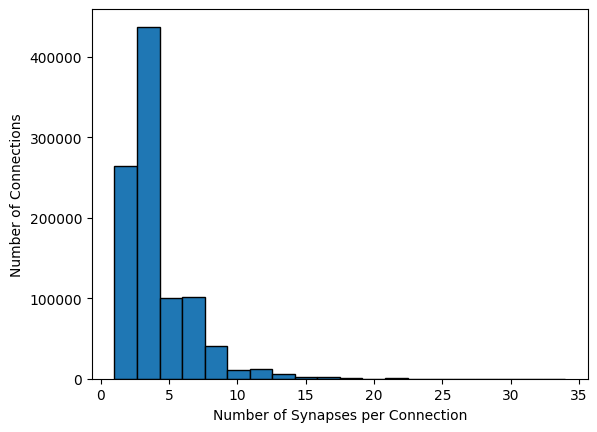

In [28]:
plt.hist(nsyn, bins=20, edgecolor='black')
plt.xlabel('Number of Synapses per Connection')
plt.ylabel('Number of Connections');

We can also build the empirical distribution of each parameter. Let's start with the conductance.

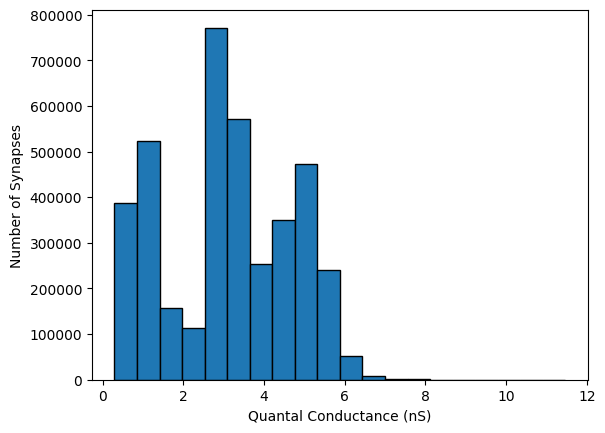

In [29]:
plt.hist(synapses[Synapse.G_SYNX].values, bins=20, edgecolor='black')
plt.xlabel('Quantal Conductance (nS)')
plt.ylabel('Number of Synapses');

If we now repeat the previous analysis to characterize the distribution of usyn, dsyn and fsyn:

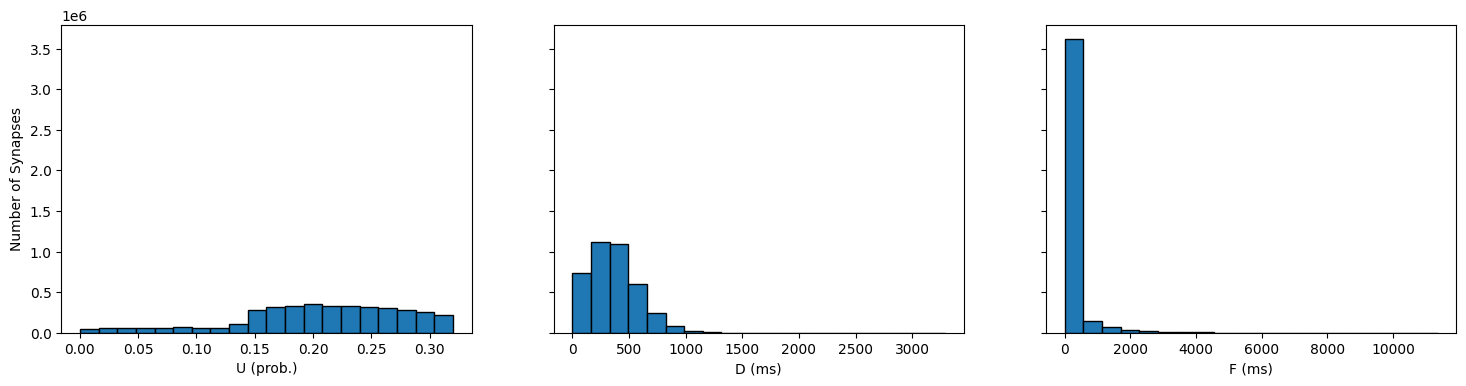

In [30]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(18, 4))

ax0.hist(synapses[Synapse.U_SYN].values, bins=20, edgecolor='black')
ax0.set_xlabel('U (prob.)')
ax0.set_ylabel('Number of Synapses')

ax1.hist(synapses[Synapse.D_SYN].values, bins=20, edgecolor='black')
ax1.set_xlabel('D (ms)')

ax2.hist(synapses[Synapse.F_SYN].values, bins=20, edgecolor='black')
ax2.set_xlabel('F (ms)');

### Displaying the synapse positions and the soma

We can also display the positions of a synapses from a cell. We dispose in bluepy of function to facilitate the extraction of the different position of the synapses:

In [31]:
postgid = 3
synapses =  circuit.connectome.afferent_synapses(postgid, properties=[Synapse.PRE_X_CONTOUR, Synapse.PRE_Y_CONTOUR, Synapse.PRE_Z_CONTOUR,])

In [32]:
synapses.head()

,Synapse.PRE_X_CONTOUR,Synapse.PRE_Y_CONTOUR,Synapse.PRE_Z_CONTOUR
48,621.065857,607.964355,1013.253174
49,625.637695,604.142029,1014.692078
50,620.615234,495.762848,960.285156
51,671.705872,636.261292,997.238953
52,630.110352,597.147400,1025.488281


In [33]:
synapses.size

90

Is similar to:

In [34]:
synapse_xyz = circuit.connectome.synapse_positions(synapses.index, 'pre', 'contour')
synapse_xyz.head()

,x,y,z
48,621.065857,607.964355,1013.253174
49,625.637695,604.142029,1014.692078
50,620.615234,495.762848,960.285156
51,671.705872,636.261292,997.238953
52,630.110352,597.147400,1025.488281


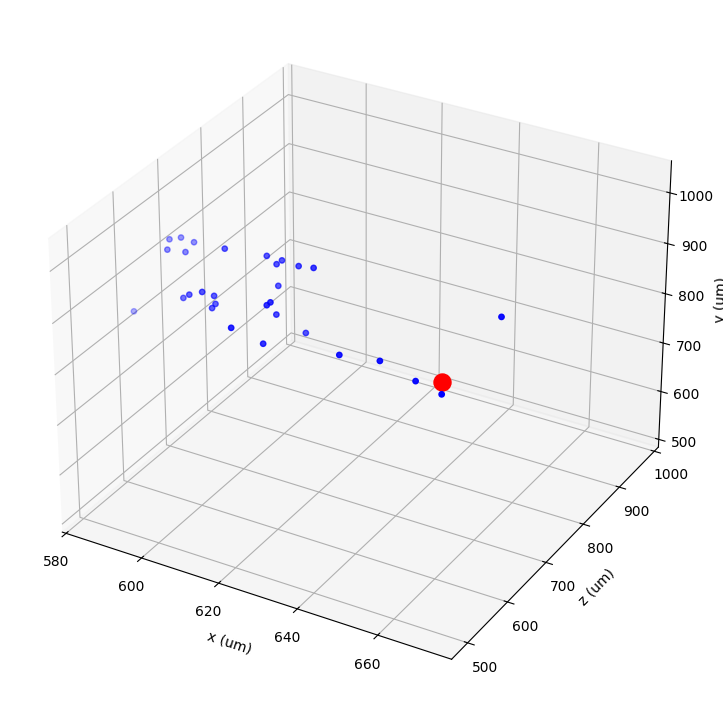

In [35]:
soma_xyz = circuit.cells.get(postgid, [Cell.X, Cell.Y, Cell.Z])

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')

# Show synapses in blue
ax.scatter(
    synapse_xyz['x'],
    synapse_xyz['y'],
    synapse_xyz['z'],
    s=15, c='b')
        
# Show postsynaptic soma in red
ax.scatter(
    soma_xyz[Cell.X],
    soma_xyz[Cell.Z],
    soma_xyz[Cell.Y],
    s=150, c='r'
)

ax.set_xlabel('x (um)')
ax.set_ylabel('z (um)')
ax.set_zlabel('y (um)');

Similarly, we can extract other useful information, such as the distance of those synapses from soma / branch point.

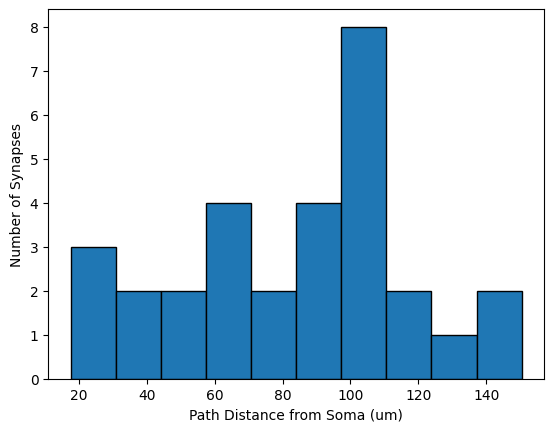

In [36]:
prop = circuit.connectome.synapse_properties(synapses.index, Synapse.POST_NEURITE_DISTANCE)

plt.hist(prop, edgecolor='black')
plt.xlabel('Path Distance from Soma (um)')
plt.ylabel('Number of Synapses');

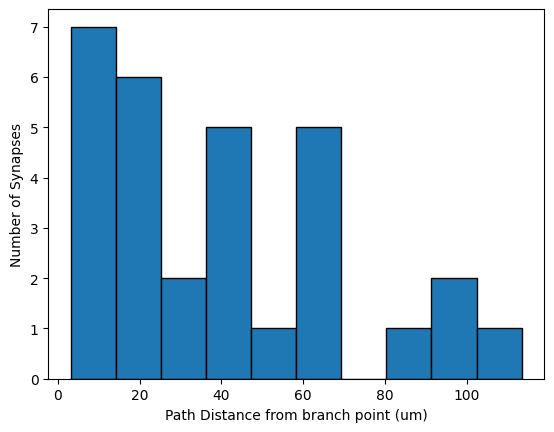

In [37]:
prop = circuit.connectome.synapse_properties(synapses.index, Synapse.POST_SECTION_DISTANCE)

plt.hist(prop, edgecolor='black')
plt.xlabel('Path Distance from branch point (um)')
plt.ylabel('Number of Synapses');

In [38]:
plt.close('all')